In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader #Dataset, DataLoader
from torchvision import datasets, transforms

하단의 code snippets는 corrupted 된 이미지를 확인하고 제거하기 위한 코드 입니다. Cats vs Dogs데이터셋에도 원인 모를 이유 때문에 이미지 데이터가 corrupt된 파일이 2개가 존재합니다. 이렇게 corrupt 된 이미지를 DataLoader로 로드시 에러가 발생하기 때문에 전처리 때 미리 제거하도록 하겠습니다.




In [2]:
# 이미지 데이터셋 다운로드
import urllib.request
import zipfile
import glob #폴더 내 파일 읽기
import os
import random
from PIL import Image, UnidentifiedImageError,ImageFile #에러 이미지 없애기

SEED = 123 #시드 설정

In [3]:
# 데이터셋을 다운로드 합니다.
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
urllib.request.urlretrieve(url, 'cats_and_dogs.zip')

('cats_and_dogs.zip', <http.client.HTTPMessage at 0x797d8fdf3130>)

In [4]:
# 다운로드 후 tmp 폴더에 압축을 해제 합니다.
local_zip = 'cats_and_dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [5]:
# 잘린 이미지 Load 시 경고 출력 안함
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
# 이미지 Validation을 수행하고 Validate 여부를 return 합니다.
def validate_image(filepath):
    try:
        # PIL.Image로 이미지 데이터를 로드하려고 시도합니다.
        img = Image.open(filepath).convert('RGB')
        img.load()
    except UnidentifiedImageError: # corrupt 된 이미지는 해당 에러를 출력합니다.
        print(f'Corrupted Image is found at: {filepath}')
        return False
    except (IOError, OSError): # Truncated (잘린) 이미지에 대한 에러를 출력합니다.
        print(f'Truncated Image is found at: {filepath}')
        return False
    else:
        return True

In [7]:
# image 데이터셋 root 폴더
root = 'tmp/PetImages'

dirs = os.listdir(root)

In [8]:
dirs

['Dog', 'Cat']

In [9]:
for dir_ in dirs:
    folder_path = os.path.join(root, dir_)
    files = os.listdir(folder_path)

    images = [os.path.join(folder_path, f) for f in files]
    for img in images:
        valid = validate_image(img)
        if not valid:
            # corrupted 된 이미지 제거
            os.remove(img)

folders = glob.glob('tmp/PetImages/*')
print(folders)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted Image is found at: tmp/PetImages/Dog/11702.jpg
Corrupted Image is found at: tmp/PetImages/Dog/Thumbs.db
Corrupted Image is found at: tmp/PetImages/Cat/Thumbs.db
Corrupted Image is found at: tmp/PetImages/Cat/666.jpg
['tmp/PetImages/Dog', 'tmp/PetImages/Cat']


Corrupted Image is found at: tmp/PetImages/Dog/11702.jpg

Corrupted Image is found at: tmp/PetImages/Dog/Thumbs.db.

Corrupted Image is found at: tmp/PetImages/Cat/Thumbs.db

Corrupted Image is found at: tmp/PetImages/Cat/666.jpg

In [10]:
# train: test ratio. 0.2로 설정시 test set의 비율은 20%로 설정
test_size = 0.2

In [11]:
# train / test 셋의 파일을 나눕니다.
train_images = []
test_images = []

In [12]:
for folder in folders:
    label = os.path.basename(folder) #folder basename
    files = sorted(glob.glob(folder + '/*'))

    # 각 Label별 이미지 데이터셋 셔플
    random.seed(SEED) #seed 설정
    random.shuffle(files) #파일 셔플

    idx = int(len(files) * test_size) # 파일 길이 * 테스트 비율 : 인덱스
    train = files[:-idx] # 훈련 데이터 : ~비율까지
    test = files[-idx:] # 테스트 데이터 : 비율부터~

    train_images.extend(train)
    test_images.extend(test)

In [13]:
# train, test 전체 이미지 셔플
random.shuffle(train_images)
random.shuffle(test_images)

In [14]:
# Class to Index 생성. {'Dog': 0, 'Cat': 1}
class_to_idx = {os.path.basename(f):idx for idx, f in enumerate(folders)}

In [15]:
# Label 생성
train_labels = [f.split('/')[-2] for f in train_images]
test_labels = [f.split('/')[-2] for f in test_images]

print('==='*10)
print(f'train images: {len(train_images)}')
print(f'train labels: {len(train_labels)}')
print(f'test images: {len(test_images)}')
print(f'test labels: {len(test_labels)}')

train images: 20000
train labels: 20000
test images: 4998
test labels: 4998


25000 개 데이터셋 중
훈련데이터 : 80% ; 20000개
테스트 데이터 : 20% : 4998개 , 2개는 잘린 이미지(cropped)

In [16]:
# dataset 상속 : CustomImageDataset 구성
class CustomImageDataset(Dataset):
    def __init__(self, files, labels, class_to_idx, transform): #파일, 라벨들, class->idx, 변환
        super(CustomImageDataset, self).__init__()
        self.files = files
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx): #여러가지 item 설정
        # file 경로
        file = self.files[idx]
        # PIL.Image로 이미지 로드 : RGB 형태
        img = Image.open(file).convert('RGB')
        # transform 적용
        img = self.transform(img)
        # label 생성
        lbl = self.class_to_idx[self.labels[idx]]
        # image, label return
        return img, lbl

In [18]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),          # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
    transforms.CenterCrop((224, 224)),      # 중앙 Crop
    transforms.RandomHorizontalFlip(0.5),   # 50% 확률로 Horizontal Flip
    transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
    transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

In [19]:
# train, test 데이터셋 생성
train_dataset = CustomImageDataset(train_images, train_labels, class_to_idx, train_transform)
test_dataset = CustomImageDataset(test_images, test_labels, class_to_idx, test_transform)

In [20]:
# train, test 데이터 로더 생성 => 모델 학습시 입력하는 데이터셋
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=8
                         )

test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=True,
                         num_workers=8
                        )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
# 1개의 배치를 추출합니다.
images, labels = next(iter(train_loader))

In [25]:
# 이미지의 shape을 확인합니다. 224 X 224 RGB 이미지 임을 확인합니다.
images[0].shape

torch.Size([3, 224, 224])

image *Visualization*

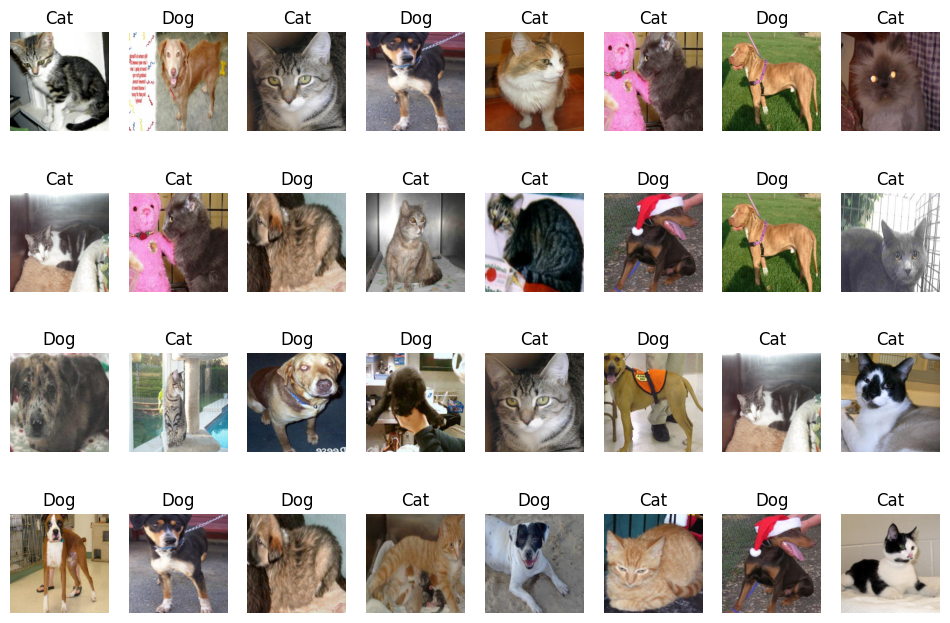

In [26]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in train_dataset.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item() #random image
    img, label = images[sample_idx], labels[sample_idx].item() #img
    figure.add_subplot(rows, cols, i) #그림 나열 개수
    plt.title(labels_map[label]) # class_to_idx 할당된 map
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [27]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [28]:
from torchvision import models # pretrained 모델을 가져오기 위한 import

# ResNet101 모델 생성
model = models.resnet101(pretrained=True) # pretrained=True 로 설정, pretrained=False로 설정되었을 경우 가중치는 가져오지 않습니다.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 178MB/s]


models.alexnet(pregrained=True) # AlexNet

models.vgg16(pretrained=True) # VGG16

models.resnet18(pretrained=True) # ResNet18

models.inception_v3(pretrained=True) # Inception_V3

In [29]:
# 가중치를 Freeze 하여 학습시 업데이트가 일어나지 않도록 설정합니다.
for param in model.parameters():
    param.requires_grad = False  # 가중치 Freeze

In [30]:
import torch.nn as nn


# Fully-Connected Layer를 Sequential로 생성하여 VGG pretrained 모델의 'Classifier'에 연결합니다.
fc = nn.Sequential(
    nn.Linear(2048, 256), # VGG16 모델의 features의 출력이 7X7, 512장 이기 때문에 in_features=7*7*512 로 설정합니다.
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2), # Cats vs Dogs 이진 분류이기 때문에 2로 out_features=2로 설정합니다.
)

In [39]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # or "n"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # or "cuda:n"

In [40]:
print(device)

cuda:0


In [41]:
model.fc = fc
model.to(device)
# 모델의 구조도 출력
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
import torch.optim as optim

In [43]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [44]:
from tqdm import tqdm  # Progress Bar 출력

In [45]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()

    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)

        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)

        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)

        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()

        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)

    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [46]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다.
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()

    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()

            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [47]:
# 최대 Epoch을 지정합니다.
num_epochs = 10
model_name = 'vgg16-pretrained'

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{model_name}.pth')

    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

  0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 62%|██████▏   | 385/625 [01:15<00:41,  5.77it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [01:59<00:00,  5.22it/s]


[INFO] val_loss has been improved from inf to 0.04149. Saving Model!
epoch 01, loss: 0.08009, acc: 0.97060, val_loss: 0.04149, val_accuracy: 0.98599


 59%|█████▉    | 369/625 [01:12<00:45,  5.61it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [02:00<00:00,  5.20it/s]


[INFO] val_loss has been improved from 0.04149 to 0.03856. Saving Model!
epoch 02, loss: 0.05336, acc: 0.98040, val_loss: 0.03856, val_accuracy: 0.98699


 34%|███▍      | 211/625 [00:42<01:14,  5.58it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [02:00<00:00,  5.18it/s]


[INFO] val_loss has been improved from 0.03856 to 0.03763. Saving Model!
epoch 03, loss: 0.04595, acc: 0.98190, val_loss: 0.03763, val_accuracy: 0.98639


 25%|██▌       | 158/625 [00:31<01:23,  5.60it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [01:59<00:00,  5.22it/s]


[INFO] val_loss has been improved from 0.03763 to 0.03453. Saving Model!
epoch 04, loss: 0.04544, acc: 0.98200, val_loss: 0.03453, val_accuracy: 0.98820


 26%|██▌       | 164/625 [00:32<01:21,  5.65it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [01:57<00:00,  5.32it/s]


epoch 05, loss: 0.04806, acc: 0.98150, val_loss: 0.04208, val_accuracy: 0.98419


 16%|█▌        | 101/625 [00:19<01:44,  5.01it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [01:56<00:00,  5.38it/s]


epoch 06, loss: 0.04099, acc: 0.98355, val_loss: 0.04236, val_accuracy: 0.98499


 16%|█▌        | 99/625 [00:20<01:50,  4.75it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [01:56<00:00,  5.36it/s]


epoch 07, loss: 0.04356, acc: 0.98290, val_loss: 0.05160, val_accuracy: 0.97899


 43%|████▎     | 268/625 [00:51<01:03,  5.66it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [01:57<00:00,  5.34it/s]


[INFO] val_loss has been improved from 0.03453 to 0.03384. Saving Model!
epoch 08, loss: 0.03880, acc: 0.98525, val_loss: 0.03384, val_accuracy: 0.98780


 27%|██▋       | 169/625 [00:32<01:18,  5.80it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [01:55<00:00,  5.40it/s]


epoch 09, loss: 0.03820, acc: 0.98590, val_loss: 0.03507, val_accuracy: 0.98739


 22%|██▏       | 136/625 [00:26<01:38,  4.98it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 625/625 [01:56<00:00,  5.37it/s]


[INFO] val_loss has been improved from 0.03384 to 0.03382. Saving Model!
epoch 10, loss: 0.03605, acc: 0.98725, val_loss: 0.03382, val_accuracy: 0.98820


In [48]:
# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load(f'{model_name}.pth'))

<ipython-input-48-3a2a017857c7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_name}.pth'))


<All keys matched successfully>

In [49]:
# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.03382, evaluation accuracy: 0.98820
